<a href="https://colab.research.google.com/github/davidnalbandyann/ACA_homework/blob/main/adversarial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Generating human faces with Adversarial Networks
<img src="https://www.strangerdimensions.com/wp-content/uploads/2013/11/reception-robot.jpg" width=320>
This time we'll train a neural net to generate plausible human faces in all their subtlty: appearance, expression, accessories, etc.

Based on https://github.com/Lasagne/Recipes/pull/94 .

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
plt.rcParams.update({'axes.titlesize': 'small'})

from sklearn.datasets import load_digits
#The following line fetches you two datasets: images, usable for autoencoder training and attributes.
import numpy as np
import os
from cv2 import imread, resize
import pandas as pd

def fetch_lfw_dataset(attrs_name = "lfw_attributes.txt",
                      images_name = "lfw-deepfunneled",
                      raw_images_name = "lfw",
                      use_raw=False,
                      dx=80,dy=80,
                      dimx=45,dimy=45
    ):#sad smile

    #download if not exists
    if (not use_raw) and not os.path.exists(images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(images_name)

    if use_raw and not os.path.exists(raw_images_name):
        print("images not found, donwloading...")
        os.system("wget http://vis-www.cs.umass.edu/lfw/lfw.tgz -O tmp.tgz")
        print("extracting...")
        os.system("tar xvzf tmp.tgz && rm tmp.tgz")
        print("done")
        assert os.path.exists(raw_images_name)

    if not os.path.exists(attrs_name):
        print("attributes not found, downloading...")
        os.system("wget http://www.cs.columbia.edu/CAVE/databases/pubfig/download/%s"%attrs_name)
        print("done")

    #read attrs
    df_attrs = pd.read_csv("lfw_attributes.txt",sep='\t',skiprows=1,)
    df_attrs = pd.DataFrame(df_attrs.iloc[:,:-1].values, columns = df_attrs.columns[1:])
    df_attrs.imagenum = df_attrs.imagenum.astype(np.int64)


    #read photos
    dirname = raw_images_name if use_raw else images_name
    photo_ids = []
    for dirpath, dirnames, filenames in os.walk(dirname):
        for fname in filenames:
            if fname.endswith(".jpg"):
                fpath = os.path.join(dirpath,fname)
                photo_id = fname[:-4].replace('_',' ').split()
                person_id = ' '.join(photo_id[:-1])
                photo_number = int(photo_id[-1])
                photo_ids.append({'person':person_id,'imagenum':photo_number,'photo_path':fpath})

    photo_ids = pd.DataFrame(photo_ids)

    #mass-merge
    #(photos now have same order as attributes)
    df = pd.merge(df_attrs,photo_ids,on=('person','imagenum'))

    assert len(df)==len(df_attrs),"lost some data when merging dataframes"

    #image preprocessing
    all_photos = df['photo_path'].apply(imread)\
                                 .apply(lambda img: img[dy:-dy,dx:-dx])\
                                 .apply(lambda img: resize(img, (dimx, dimy)))

    all_photos = np.stack(all_photos.values).astype('uint8')
    all_attrs = df.drop(["photo_path","person","imagenum"],axis=1)

    return all_photos,all_attrs
data,attrs = fetch_lfw_dataset(dimx=36,dimy=36)

#preprocess faces
data = np.float32(data)/255.

IMG_SHAPE = data.shape[1:]

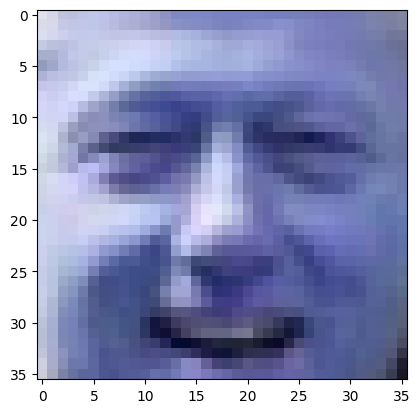

In [5]:
#print random image
plt.imshow(data[np.random.randint(data.shape[0])], cmap="gray", interpolation="none")

# Generative adversarial nets 101

<img src="https://raw.githubusercontent.com/torch/torch.github.io/master/blog/_posts/images/model.png" width=320px height=240px>

Deep learning is simple, isn't it?
* build some network that generates the face (small image)
* make up a __measure__ of __how good that face is__
* optimize with gradient descent


The only problem is: how can we tell well-generated faces from bad?

__If we can't tell good faces from bad, we delegate it to yet another neural network!__

That makes the two of them:
* __G__enerator - takes random noize for inspiration and tries to generate a face sample.
  * Let's call him __G__(z), where z is a gaussian noize.
* __D__iscriminator - takes a face sample and tries to tell if it's great or fake.
  * Predicts the probability of input image being a __real face__
  * Let's call him __D__(x), x being an image.
  * __D(x)__ is a predition for real image and __D(G(z))__ is prediction for the face made by generator.

Before we dive into training them, let's construct the two networks.

In [6]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras import layers as L

In [7]:
CODE_SIZE = 256

generator = Sequential()
generator.add(L.InputLayer([CODE_SIZE],name='noise'))
generator.add(L.Dense(10*8*8, activation='elu'))

generator.add(L.Reshape((8,8,10)))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.Conv2DTranspose(64,kernel_size=(5,5),activation='elu'))
generator.add(L.UpSampling2D(size=(2,2)))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))
#generator.add(L.Conv2DTranspose(32,kernel_size=3,activation='elu'))

generator.add(L.Conv2DTranspose(3, kernel_size=(3, 3), activation='sigmoid', padding='same'))


In [8]:
assert generator.output_shape[1:] == IMG_SHAPE, "generator must output an image of shape %s, but instead it produces %s"%(IMG_SHAPE,generator.output_shape[1:])

### Discriminator
Discriminator is your usual convolutional network with interlooping convolution and pooling layers

In [9]:
discriminator = Sequential()

discriminator.add(L.InputLayer(IMG_SHAPE))



IMG_SHAPE = (36, 36, 3)

discriminator = tf.keras.Sequential()

# Input layer for the discriminator
discriminator.add(L.InputLayer(input_shape=IMG_SHAPE))

# Build the discriminator body (convolutional layers)
discriminator.add(L.Conv2D(64, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
discriminator.add(L.Conv2D(128, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))
discriminator.add(L.Conv2D(256, kernel_size=(3, 3), strides=(2, 2), activation='relu', padding='same'))

# Flatten the features
discriminator.add(L.Flatten())

# Add a dense layer with tanh activation
discriminator.add(L.Dense(256, activation='tanh'))

# Add the output layer with 2 units and log_softmax activation
discriminator.add(L.Dense(2, activation=tf.nn.log_softmax))

# Compile the discriminator
#discriminator.compile(optimizer='adam', loss='categorical_crossentropy')

# Generate a random fake image for testing
fake_image = np.random.rand(1, *IMG_SHAPE)
fake_prediction = discriminator.predict(fake_image)

print("Fake Image Prediction:", fake_prediction)


discriminator.add(L.Flatten())
discriminator.add(L.Dense(256,activation='tanh'))
discriminator.add(L.Dense(2,activation=tf.nn.log_softmax))

1/1 [==============================] - 2s 2s/step
Fake Image Prediction: [[-0.6921867 -0.6941085]]


# Training

We train the two networks concurrently:
* Train __discriminator__ to better distinguish real data from __current__ generator
* Train __generator__ to make discriminator think generator is real

![img](gan.png)

Training is done iteratively until discriminator is no longer able to find the difference (or until you run out of patience).


### Tricks:
* You can find useful tricks here https://github.com/soumith/ganhacks

### Auxilary functions
Here we define a few helper functions that draw current data distributions and sample training batches.

In [10]:
def sample_noise_batch(bsize):
    return np.random.normal(size=(bsize, CODE_SIZE)).astype('float32')

def sample_data_batch(bsize):
    idxs = np.random.choice(np.arange(data.shape[0]), size=bsize)
    return data[idxs]

def sample_images(nrow,ncol, sharp=False):
    images = generator.predict(sample_noise_batch(bsize=nrow*ncol))
    if np.var(images)!=0:
        images = images.clip(np.min(data),np.max(data))
    for i in range(nrow*ncol):
        plt.subplot(nrow,ncol,i+1)
        if sharp:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray", interpolation="none")
        else:
            plt.imshow(images[i].reshape(IMG_SHAPE),cmap="gray")
    plt.show()

def sample_probas(bsize):
    plt.title('Generated vs real data')
    plt.hist(np.exp(discriminator.predict(sample_data_batch(bsize)))[:,1],
             label='D(x)', alpha=0.5,range=[0,1])
    plt.hist(np.exp(discriminator.predict(generator.predict(sample_noise_batch(bsize))))[:,1],
             label='D(G(z))',alpha=0.5,range=[0,1])
    plt.legend(loc='best')
    plt.show()

### Training
Main loop.
We just train generator and discriminator in a loop and draw results once every N iterations.

In [11]:
disc_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
gen_optimizer = tf.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

1/1 [==============================] - 0s 17ms/step


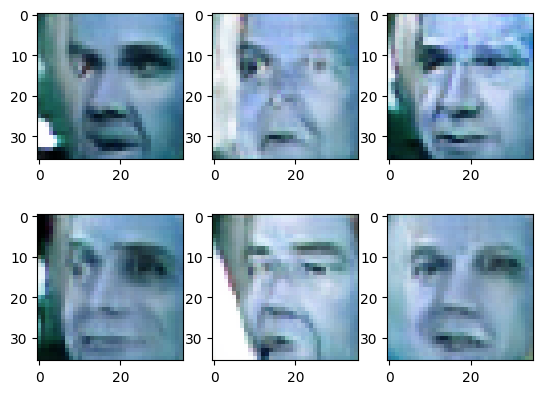

32/32 [==============================] - 0s 2ms/step


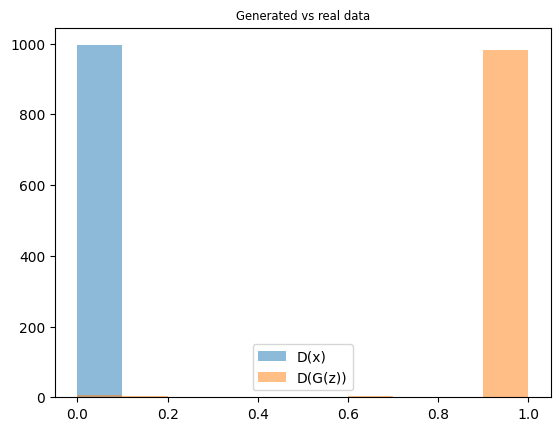

In [16]:
from IPython import display
from tqdm import tnrange

for epoch in tnrange(50000):
    real_data = sample_data_batch(100)
    noise = sample_noise_batch(100)

    ########################
    #discriminator training#
    ########################
    for i in range(5):
        with tf.GradientTape() as disc_tape:
            logp_real = discriminator(real_data)

            generated_data = generator(noise)

            logp_gen = discriminator(generated_data)

            d_loss = -tf.reduce_mean(logp_real[:, 1] + logp_gen[:, 0])
            d_loss += tf.reduce_mean(discriminator.layers[-1].kernel**2)

        # Calculate gradients and optimize
        gradients = disc_tape.gradient(d_loss, discriminator.trainable_weights)
        disc_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

    ########################
    ###generator training###
    ########################
    with tf.GradientTape() as gen_tape:
        generated_data = generator(noise)

        logp_gen = discriminator(generated_data)

        g_loss = -tf.reduce_mean(logp_gen[:, 1])

    # Calculate gradients and optimize
    gradients = gen_tape.gradient(g_loss, generator.trainable_variables)
    gen_optimizer.apply_gradients(zip(gradients, generator.trainable_variables))

    if epoch % 100 == 0:
        display.clear_output(wait=True)
        sample_images(2, 3, True)
        sample_probas(1000)


4/4 [==============================] - 0s 3ms/step


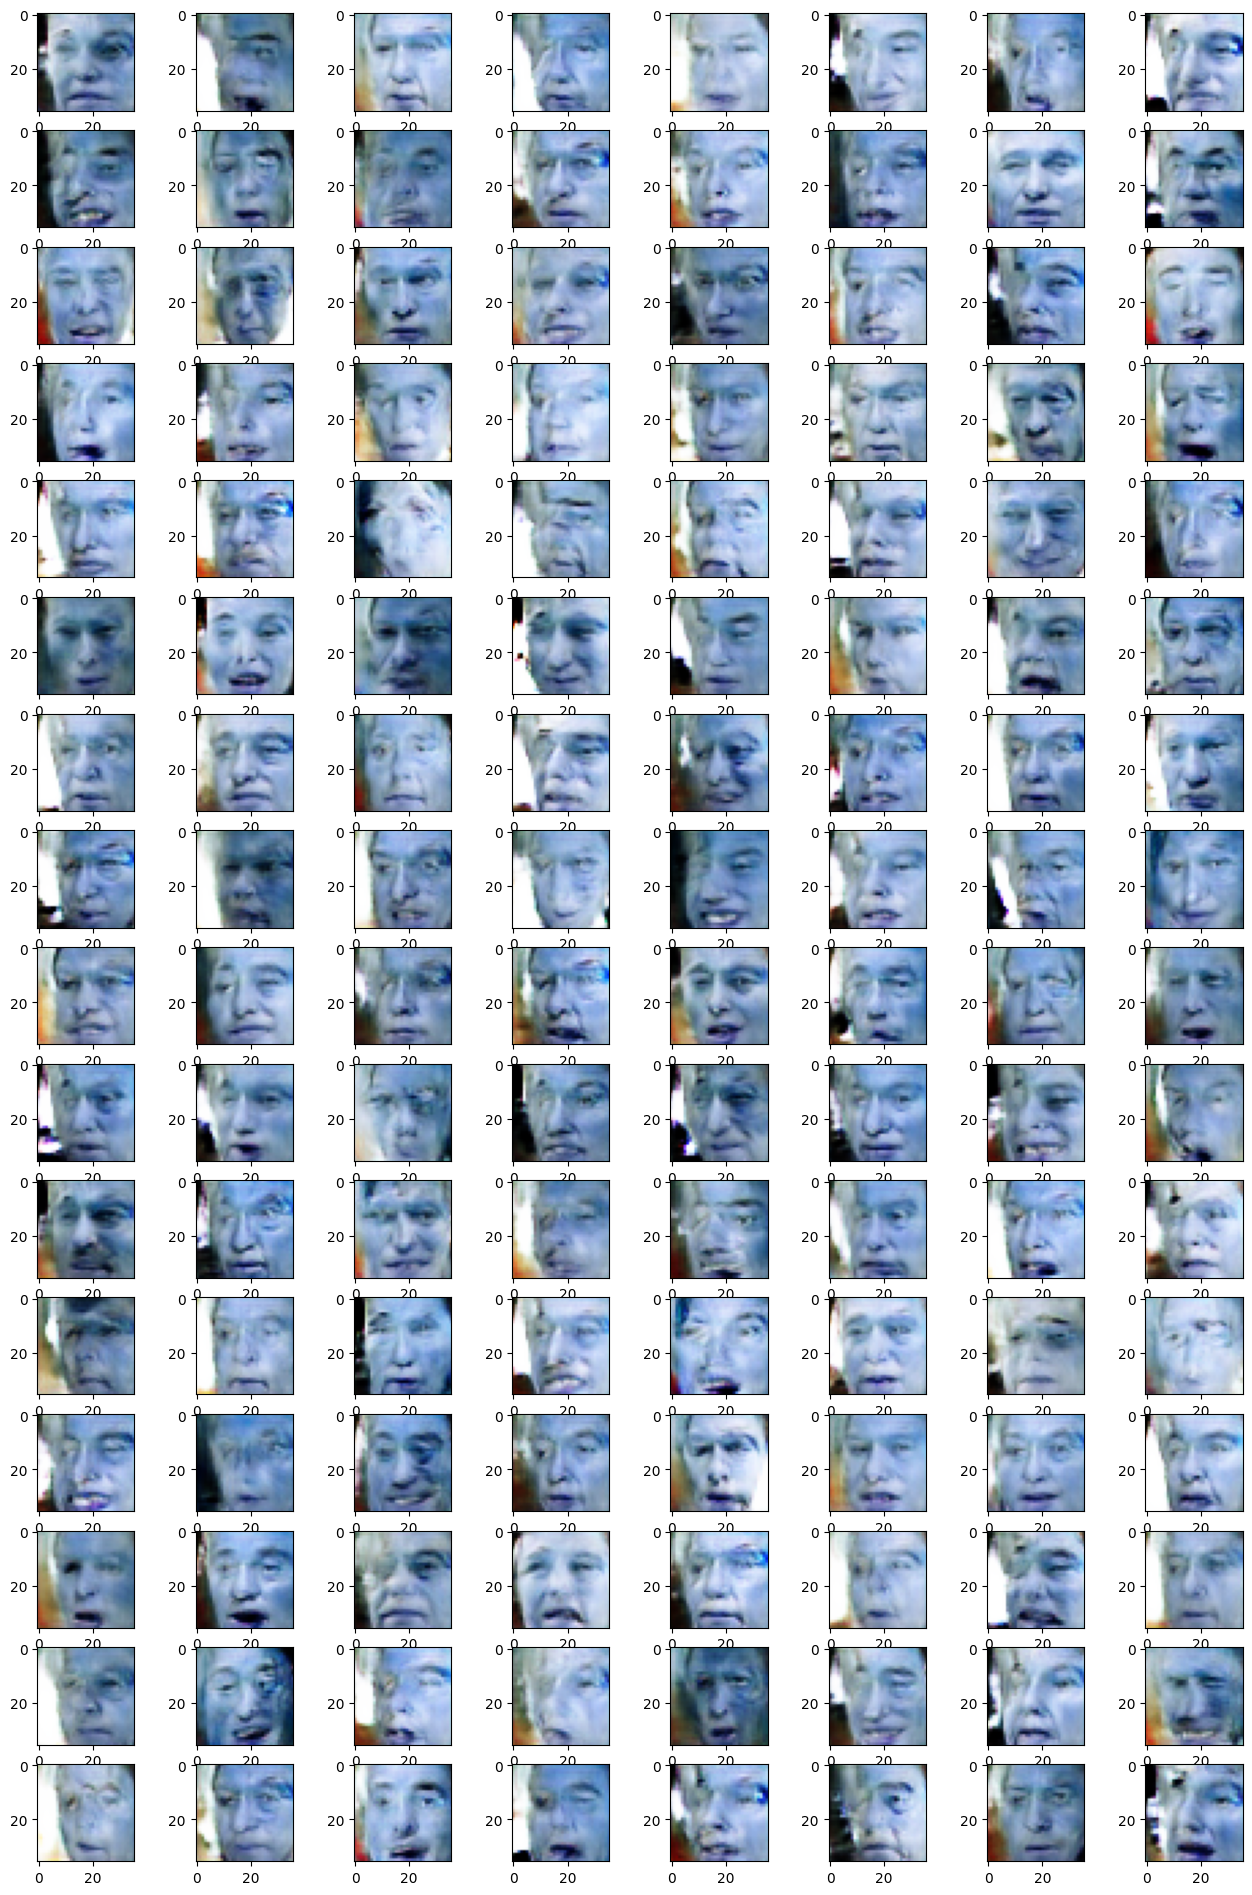

In [18]:
plt.figure(figsize=[16,24])
sample_images(16,8)